# 02 Pipeline de Treinamento

#Montando o baseline

# 01. Setup Kaggle Dataset

In [1]:
!pip install opendatasets opencv-python-headless pandas pillow matplotlib seaborn torch torchvision --quiet
!pip install pyarrow fastparquet --quiet

import os
import opendatasets as od
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import subprocess
import glob
import csv
from copy import deepcopy
from getpass import getpass
from IPython.display import clear_output

BASE_DIR = "/content/clothing-coparsing-dataset"
DATASET_URL = "https://www.kaggle.com/datasets/balraj98/clothing-coparsing-dataset"

if not os.path.exists(BASE_DIR):
    print("Dataset não encontrado. Fazendo download do Kaggle...")
    print("IMPORTANTE: insira suas credenciais da API do Kaggle (kaggle.json).")
    od.download(DATASET_URL, data_dir="/content/")
    print(f"Dataset baixado em: {BASE_DIR}")
else:
    print(f"Dataset já disponível em: {BASE_DIR}")

IMAGES_DIR = os.path.join(BASE_DIR, "images")
LABELS_DIR = os.path.join(BASE_DIR, "labels/pixel_level_labels_colored")

Dataset já disponível em: /content/clothing-coparsing-dataset


# 02. Carregar dataframe do GitHub
Se o repo é público, você pode usar o link bruto do GitHub:

In [2]:
PARQUET_URL = "https://github.com/RaphaelCarvalh/clothing-segmentation-project/raw/main/data/df_valido.parquet"
df_valido = pd.read_parquet(PARQUET_URL, engine="pyarrow")
print(f"Total válido carregado: {len(df_valido)} linhas")
df_valido.head()

Total válido carregado: 1003 linhas


,image_path_full,image_path_relative,label_path_full,label_path_relative,image_exists,label_exists,corrupted,image_hash,image_format,width,height,channels,is_duplicate,classes,num_classes,image_id
0,/content/clothing-coparsing-dataset/images/000...,images/0001.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0001.png,True,True,False,9349b423c4d40aea33b9334be15050ef,jpeg,550,832,3,False,"[hair, shoes, skin, blouse, skirt, stockings, ...",8,1
1,/content/clothing-coparsing-dataset/images/000...,images/0002.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0002.png,True,True,False,7d2824d0e04ca4fa0575fb88173a7cc1,jpeg,550,830,3,False,"[pumps, jacket, hair, dress, skin, socks]",6,2
2,/content/clothing-coparsing-dataset/images/000...,images/0003.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0003.png,True,True,False,b3671739ed055b6b2cb21bd12fab7627,jpeg,550,831,3,False,"[pants, purse, necklace, jacket, hair, dress, ...",13,3
3,/content/clothing-coparsing-dataset/images/000...,images/0004.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0004.png,True,True,False,886cfd5b1269d5c7d2566a202395ce4d,jpeg,550,810,3,False,"[pants, hat, shirt, glasses, shoes, coat, skin...",9,4
4,/content/clothing-coparsing-dataset/images/000...,images/0005.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0005.png,True,True,False,cb5c8591a2e29740db0601be07d80cc4,jpeg,550,842,3,False,"[purse, hair, shoes, dress, cape, skin, sungla...",8,5


Puxando o df com dados do dataset ja tratado Obs. Versão mais completa do import caso o repo fique privado em algum momento.

In [ ]:
# import getpass
# import pandas as pd
# import requests
# from io import StringIO

# # Pede token de forma segura
# GITHUB_TOKEN = getpass.getpass("Digite seu token GitHub: ")

# # URL do arquivo CSV
# CSV_PATH = "data/df_valido.csv"
# REPO = "RaphaelCarvalh/clothing-segmentation-project"
# RAW_URL = f"https://raw.githubusercontent.com/{REPO}/main/{CSV_PATH}"

# # Autenticação com token
# headers = {"Authorization": f"token {GITHUB_TOKEN}"}
# response = requests.get(RAW_URL, headers=headers)

# # Ler CSV na memória
# df_valido = pd.read_csv(StringIO(response.text))
# print(f"Total válido carregado: {len(df_valido)} linhas")
# df_valido.head()


# 03. Ajustar paths


In [3]:
def ajustar_paths(df):
    df_corrigido = df.copy()
    df_corrigido["image_path_full"] = df_corrigido["image_path_full"].apply(
        lambda x: os.path.join(IMAGES_DIR, os.path.basename(x)) if isinstance(x, str) else x
    )
    df_corrigido["label_path_full"] = df_corrigido["label_path_full"].apply(
        lambda x: os.path.join(LABELS_DIR, os.path.basename(x)) if isinstance(x, str) else x
    )
    return df_corrigido

df_valido = ajustar_paths(df_valido)
print("\nValidação dos caminhos após ajuste:")
print(f"Imagens encontradas: {df_valido['image_path_full'].apply(os.path.exists).sum()} / {len(df_valido)}")
print(f"Labels encontradas: {df_valido['label_path_full'].apply(os.path.exists).sum()} / {len(df_valido)}")

df_valido.head()


Validação dos caminhos após ajuste:
Imagens encontradas: 1003 / 1003
Labels encontradas: 1003 / 1003


,image_path_full,image_path_relative,label_path_full,label_path_relative,image_exists,label_exists,corrupted,image_hash,image_format,width,height,channels,is_duplicate,classes,num_classes,image_id
0,/content/clothing-coparsing-dataset/images/000...,images/0001.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0001.png,True,True,False,9349b423c4d40aea33b9334be15050ef,jpeg,550,832,3,False,"[hair, shoes, skin, blouse, skirt, stockings, ...",8,1
1,/content/clothing-coparsing-dataset/images/000...,images/0002.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0002.png,True,True,False,7d2824d0e04ca4fa0575fb88173a7cc1,jpeg,550,830,3,False,"[pumps, jacket, hair, dress, skin, socks]",6,2
2,/content/clothing-coparsing-dataset/images/000...,images/0003.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0003.png,True,True,False,b3671739ed055b6b2cb21bd12fab7627,jpeg,550,831,3,False,"[pants, purse, necklace, jacket, hair, dress, ...",13,3
3,/content/clothing-coparsing-dataset/images/000...,images/0004.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0004.png,True,True,False,886cfd5b1269d5c7d2566a202395ce4d,jpeg,550,810,3,False,"[pants, hat, shirt, glasses, shoes, coat, skin...",9,4
4,/content/clothing-coparsing-dataset/images/000...,images/0005.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0005.png,True,True,False,cb5c8591a2e29740db0601be07d80cc4,jpeg,550,842,3,False,"[purse, hair, shoes, dress, cape, skin, sungla...",8,5


# 05. Selecionar top 5 classes


In [4]:
import ast
from collections import Counter

# Converter a coluna 'classes' (que está como string) para lista real
if isinstance(df_valido.iloc[0]["classes"], str):
    df_valido["classes"] = df_valido["classes"].apply(ast.literal_eval)

# Contar frequência total de todas as classes
all_classes = [cls for sublist in df_valido["classes"] for cls in sublist]
class_counts = Counter(all_classes)

# Mostrar as 10 classes mais frequentes
print(" Classes mais frequentes:")
for cls, count in class_counts.most_common(10):
    print(f"{cls}: {count}")

# Selecionar apenas as 5 classes mais comuns
top_classes = [cls for cls, _ in class_counts.most_common(5)]
print(f"\n Mantendo apenas as 5 classes mais comuns: {top_classes}")

# Filtrar o dataframe para manter apenas imagens que contenham pelo menos uma dessas classes
df_filtrado = df_valido[df_valido["classes"].apply(lambda cls_list: any(c in top_classes for c in cls_list))].reset_index(drop=True)

print(f" Total de imagens após filtro: {len(df_filtrado)} (de {len(df_valido)} originais)")
print(f" Proporção entre : {len(df_filtrado) / len(df_valido) * 100:.2f}%")

 Classes mais frequentes:
skin: 1002
hair: 959
shoes: 774
bag: 443
pants: 302
sunglasses: 293
dress: 270
purse: 234
coat: 232
accessories: 223

 Mantendo apenas as 5 classes mais comuns: ['skin', 'hair', 'shoes', 'bag', 'pants']
 Total de imagens após filtro: 1002 (de 1003 originais)
 Proporção entre : 99.90%


# 04. Divisão train/val/test

In [5]:
from sklearn.model_selection import train_test_split

# Configurar proporções (ex: 70% train, 15% val, 15% test)
train_size = 0.7
val_size = 0.15
test_size = 0.15

# Primeiro: separar train e temp (val+test)
df_train, df_temp = train_test_split(
    df_filtrado,
    train_size=train_size,
    random_state=42,
    shuffle=True
)

# Depois: dividir temp em val e test
relative_val_size = val_size / (val_size + test_size)  # ajuste proporcional
df_val, df_test = train_test_split(
    df_temp,
    train_size=relative_val_size,
    random_state=42,
    shuffle=True
)

print("Tamanhos finais:")
print(f"Train: {len(df_train)} imagens")
print(f"Val:   {len(df_val)} imagens")
print(f"Test:  {len(df_test)} imagens")

# Confirmar que não houve sobreposição
assert set(df_train.index).isdisjoint(df_val.index)
assert set(df_train.index).isdisjoint(df_test.index)
assert set(df_val.index).isdisjoint(df_test.index)

# Conferir algumas amostras
print("\nExemplo Train:")
display(df_train.head())
print("\nExemplo Val:")
display(df_val.head())
print("\nExemplo Test:")
display(df_test.head())


Tamanhos finais:
Train: 701 imagens
Val:   150 imagens
Test:  151 imagens

Exemplo Train:


,image_path_full,image_path_relative,label_path_full,label_path_relative,image_exists,label_exists,corrupted,image_hash,image_format,width,height,channels,is_duplicate,classes,num_classes,image_id
440,/content/clothing-coparsing-dataset/images/044...,images/0442.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0442.png,True,True,False,eae1bb06b0c1f9f58719395d90177dc6,jpeg,550,829,3,False,"[purse, necklace, leggings, jacket, hat, hair,...",10,442
482,/content/clothing-coparsing-dataset/images/048...,images/0484.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0484.png,True,True,False,5f9919177512091c5d27435e1f1f6c96,jpeg,550,842,3,False,"[hair, flats, shorts, skin, blouse, sunglasses...",7,484
422,/content/clothing-coparsing-dataset/images/042...,images/0424.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0424.png,True,True,False,39ca400165bdccc78eb1d46de6f442fd,jpeg,550,825,3,False,"[jeans, hair, shoes, coat, skin, bag, sweater]",7,424
780,/content/clothing-coparsing-dataset/images/078...,images/0783.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0783.png,True,True,False,31c437aea721568d2cf405794dd74ebc,jpeg,550,817,3,False,"[hair, dress, skin, boots, bag, blazer]",6,783
951,/content/clothing-coparsing-dataset/images/095...,images/0954.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0954.png,True,True,False,91367584ffd0455e5303d79fcc672140,jpeg,550,830,3,False,"[pants, hat, shirt, hair, coat, skin, boots, b...",9,954



Exemplo Val:


,image_path_full,image_path_relative,label_path_full,label_path_relative,image_exists,label_exists,corrupted,image_hash,image_format,width,height,channels,is_duplicate,classes,num_classes,image_id
67,/content/clothing-coparsing-dataset/images/006...,images/0069.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0069.png,True,True,False,d803be5e1e6060ee5bee503146237825,jpeg,550,860,3,False,"[pants, purse, hat, shirt, hair, skin, accesso...",9,69
109,/content/clothing-coparsing-dataset/images/011...,images/0111.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0111.png,True,True,False,24a6de2e7c1a446e591bd5a34e5b5899,jpeg,550,835,3,False,"[jeans, jacket, hair, shoes, skin, sweater]",6,111
961,/content/clothing-coparsing-dataset/images/096...,images/0964.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0964.png,True,True,False,45b5aaa96bb97e2966942b0ad531ae87,jpeg,550,825,3,False,"[pants, scarf, hat, hair, coat, skin, boots]",7,964
462,/content/clothing-coparsing-dataset/images/046...,images/0464.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0464.png,True,True,False,b1fc940c6fa129a06da0f8491195e121,jpeg,550,820,3,False,"[hair, shoes, coat, skin, bag, blouse, skirt]",7,464
290,/content/clothing-coparsing-dataset/images/029...,images/0292.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0292.png,True,True,False,7011afadf0524ed85f00c9cef6a046cf,jpeg,550,816,3,False,"[pants, hat, shoes, skin, accessories, sweater]",6,292



Exemplo Test:


,image_path_full,image_path_relative,label_path_full,label_path_relative,image_exists,label_exists,corrupted,image_hash,image_format,width,height,channels,is_duplicate,classes,num_classes,image_id
259,/content/clothing-coparsing-dataset/images/026...,images/0261.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0261.png,True,True,False,a633bd3440b052aede73b27b8725a1b1,jpeg,550,825,3,False,"[pants, sandals, shirt, hair, bracelet, skin, ...",10,261
858,/content/clothing-coparsing-dataset/images/086...,images/0861.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0861.png,True,True,False,2006f9fcfe0bddff8433c10ec2d1f6a9,jpeg,550,832,3,False,"[pants, jacket, shirt, hair, skin, boots, vest]",7,861
906,/content/clothing-coparsing-dataset/images/090...,images/0909.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0909.png,True,True,False,68e054c94674e927009879549dc40a7a,jpeg,550,825,3,False,"[jeans, shirt, hair, shoes, skin]",5,909
615,/content/clothing-coparsing-dataset/images/061...,images/0618.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0618.png,True,True,False,32a4ea9d947ef0f7ed3c263a56e366ff,jpeg,550,814,3,False,"[purse, jeans, shirt, hair, shoes, skin, acces...",7,618
296,/content/clothing-coparsing-dataset/images/029...,images/0298.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0298.png,True,True,False,69c04e0a931378dae2b9b9c9de9812b7,jpeg,550,832,3,False,"[hair, coat, bracelet, skin, boots, blouse, sk...",8,298


# 05. Dataset & DataLoader


In [6]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

class ClothingSegmentationDataset(Dataset):
    def __init__(self, df, transform_img=None, transform_mask=None):
        self.df = df
        self.transform_img = transform_img
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["image_path_full"]).convert("RGB")
        mask = Image.open(row["label_path_full"]).convert("L")  # grayscale

        if self.transform_img:
            img = self.transform_img(img)

        if self.transform_mask:
            mask = self.transform_mask(mask)
            # Converte para long (CrossEntropyLoss exige)
            mask = torch.from_numpy(np.array(mask)).long()

        return img, mask

# Transforms
train_img_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_mask_transforms = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST)
])

# Criar datasets
train_dataset = ClothingSegmentationDataset(df_train, train_img_transforms, train_mask_transforms)
val_dataset = ClothingSegmentationDataset(df_val, train_img_transforms, train_mask_transforms)
test_dataset = ClothingSegmentationDataset(df_test, train_img_transforms, train_mask_transforms)

# Detectar GPU
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Usando dispositivo: {device}")

# DataLoaders (ajustados)
BATCH_SIZE = 12   # pode aumentar se couber na GPU
NUM_WORKERS = 2  # mais estável no Colab/Compute Engine
PIN_MEMORY = True if device.type == "cuda" else False

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

print(f"DataLoaders configurados: batch_size={BATCH_SIZE}, num_workers={NUM_WORKERS}, pin_memory={PIN_MEMORY}")


 Usando dispositivo: cuda
DataLoaders configurados: batch_size=12, num_workers=2, pin_memory=True


# 06. Modelo deeplabv3_resnet50


In [7]:
from torchvision.models.segmentation import deeplabv3_resnet50

num_classes = len(top_classes)
model = deeplabv3_resnet50(weights="DEFAULT")
model.classifier[-1] = torch.nn.Conv2d(256, num_classes, kernel_size=(1,1))
model = model.to(device)   # <-- envia modelo para GPU

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Otimização extra (acelera convoluções)
torch.backends.cudnn.benchmark = True

# 07. Funções de treino/validação


In [8]:
from tqdm import tqdm

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for imgs, masks in tqdm(loader, desc="Treinando", leave=False):
        imgs = imgs.to(device, non_blocking=True)              # <-- ajustado
        masks = masks.squeeze(1).long().to(device, non_blocking=True)  # <-- ajustado
        optimizer.zero_grad()
        outputs = model(imgs)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def eval_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc="Validando", leave=False):
            imgs = imgs.to(device, non_blocking=True)              # <-- ajustado
            masks = masks.squeeze(1).long().to(device, non_blocking=True)  # <-- ajustado
            outputs = model(imgs)['out']
            loss = criterion(outputs, masks)
            total_loss += loss.item()
    return total_loss / len(loader)


# 08. Setup GitHub & Drive para checkpoints


In [9]:
# Monta o Drive
from google.colab import drive
drive.mount('/content/drive')

# Pasta de checkpoints
SAVE_DIR = "/content/drive/MyDrive/clothing_segmentation_pasta/checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)

# Função para carregar último checkpoint
import glob
import torch

def carregar_ultimo_checkpoint(model, optimizer, device):
    ckpts = sorted(glob.glob(os.path.join(SAVE_DIR, "checkpoint_epoch_*.pt")))
    if not ckpts:
        print(" Nenhum checkpoint encontrado. Começando do zero.")
        return 0, float("inf"), [], []

    ultimo = ckpts[-1]
    print(f" Carregando último checkpoint: {os.path.basename(ultimo)}")
    ckpt = torch.load(ultimo, map_location=device)
    model.load_state_dict(ckpt["model_state"])
    optimizer.load_state_dict(ckpt["optimizer_state"])
    return ckpt["epoch"], ckpt["best_loss"], ckpt["train_losses"], ckpt["val_losses"]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 10. Loop de Treinamento com GitHub + Drive


In [ ]:
from copy import deepcopy
import matplotlib.pyplot as plt
from IPython.display import clear_output
import csv
import os
import glob
import torch
from tqdm import tqdm

# --- Caminho para log CSV ---
LOG_PATH = os.path.join(SAVE_DIR, "log_treinamento.csv")

# --- Função para salvar checkpoint ---
def salvar_checkpoint(model, optimizer, epoch, train_losses, val_losses, best_loss):
    checkpoint_path = os.path.join(SAVE_DIR, f"checkpoint_epoch_{epoch}.pt")
    torch.save({
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "train_losses": train_losses,
        "val_losses": val_losses,
        "best_loss": best_loss
    }, checkpoint_path)
    print(f" Checkpoint salvo: {checkpoint_path}")

# --- Função para carregar último checkpoint ---
def carregar_ultimo_checkpoint(model, optimizer, device):
    checkpoint_files = sorted(glob.glob(os.path.join(SAVE_DIR, "checkpoint_epoch_*.pt")))
    if checkpoint_files:
        latest_ckpt = checkpoint_files[-1]
        ckpt = torch.load(latest_ckpt, map_location=device)
        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])
        print(f" Retomando do checkpoint: {os.path.basename(latest_ckpt)}")
        return ckpt["epoch"], ckpt.get("best_loss", float("inf")), ckpt.get("train_losses", []), ckpt.get("val_losses", [])
    else:
        print(" Nenhum checkpoint encontrado, começando do zero.")
        return 0, float("inf"), [], []

# --- Preparar início do treino ---
prev_epoch, best_loss, train_losses, val_losses = carregar_ultimo_checkpoint(model, optimizer, device)
best_model = deepcopy(model)
start_epoch = prev_epoch + 1

# --- Cria log CSV se não existir ---
if not os.path.exists(LOG_PATH):
    with open(LOG_PATH, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "train_loss", "val_loss", "best_loss"])
    print(" Criando novo log de treinamento.")
else:
    print(f" Retomando treino a partir da época {start_epoch}")
EPOCHS = 15
print(f" Treinamento continua da época {start_epoch}/{EPOCHS} | Melhor loss anterior: {best_loss:.4f}")

# --- Loop de treino ---
for epoch in range(start_epoch, EPOCHS + 1):
    # Treino
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    # Validação
    val_loss   = eval_epoch(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Atualiza melhor modelo
    if val_loss < best_loss:
        best_model = deepcopy(model)
        best_loss = val_loss
        torch.save(best_model.state_dict(), os.path.join(SAVE_DIR, "best_model_final.pt"))

    # Acrescenta linha ao CSV
    with open(LOG_PATH, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([epoch, train_loss, val_loss, best_loss])

    # Salva checkpoint
    salvar_checkpoint(model, optimizer, epoch, train_losses, val_losses, best_loss)

    # Atualiza gráfico em tempo real
    clear_output(wait=True)
    plt.figure(figsize=(8,4))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Treinando: Epoch {epoch}/{EPOCHS}")
    plt.legend()
    plt.show()

    # Print de controle
    print(f"Epoch {epoch}: Train Loss={train_loss:.4f} | Val Loss={val_loss:.4f} | Melhor Loss={best_loss:.4f}")


 Nenhum checkpoint encontrado, começando do zero.
 Criando novo log de treinamento.
 Treinamento continua da época 1/15 | Melhor loss anterior: inf


#Gráficos de Loss e Métricas

In [ ]:
import matplotlib.pyplot as plt

def plot_training_curves(train_losses, val_losses):
    plt.figure(figsize=(8,4))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.title("Evolução da Loss durante o Treinamento")
    plt.legend()
    plt.grid(True)
    plt.show()

# Chame após o loop de treino
plot_training_curves(train_losses, val_losses)

#Visualização Qualitativa de Predições

In [ ]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt

# Função para desnormalizar imagens para visualização
def denormalize_img(tensor_img):
    """
    tensor_img: C x H x W (normalizado)
    retorna: H x W x C com valores em [0,1] para plt.imshow
    """
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    img = tensor_img * std + mean
    img = img.permute(1,2,0).cpu().numpy()  # H x W x C
    img = np.clip(img, 0, 1)
    return img

# Função para visualizar predições
def visualize_predictions(model, dataset, device, num_samples=3):
    model.eval()
    plt.figure(figsize=(12, num_samples * 8))

    for i in range(num_samples):
        idx = random.randint(0, len(dataset)-1)
        img, mask = dataset[idx]

        img_vis = denormalize_img(img)
        mask_vis = mask.squeeze()  # remove C=1

        with torch.no_grad():
            output = model(img.unsqueeze(0).to(device))['out']
            pred = torch.argmax(output.squeeze(), dim=0).cpu()  # H x W

        # Imagem Original
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(img_vis)
        plt.title("Imagem Original")
        plt.axis("off")

        # Máscara Real
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(mask_vis, cmap="gray")
        plt.title("Máscara Real")
        plt.axis("off")

        # Predição do Modelo
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(pred, cmap="gray")
        plt.title("Predição")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Uso: após o seu loop de treino
visualize_predictions(best_model, val_dataset, device, num_samples=3)


Calculando métricas no conjunto de validação...
Pixel Accuracy (global): 0.0000
Mean IoU: 0.0000
Dice Coefficient por classe: [0. 0. 0. 0. 0.]
Class-wise Pixel Accuracy: [0. 0. 0. 0. 0.]


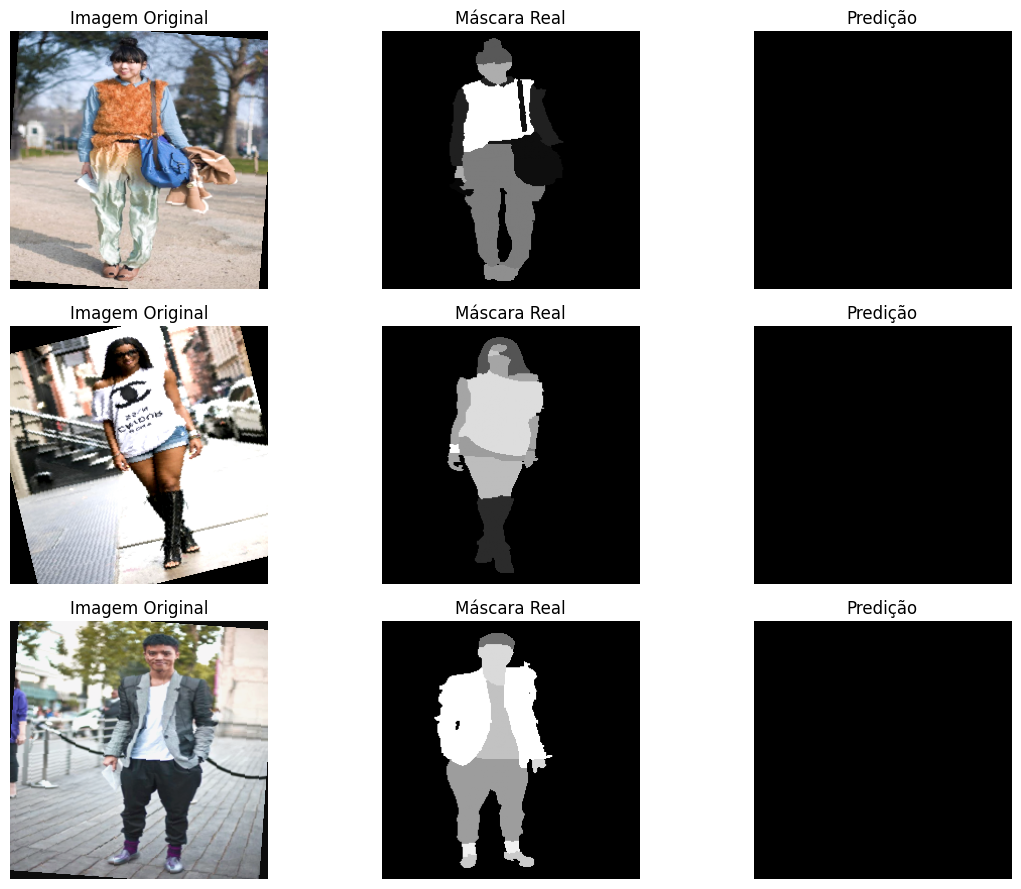

In [47]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random

# Função para desnormalizar imagens para visualização
def denormalize_img(tensor_img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    img = tensor_img * std + mean
    img = img.permute(1,2,0).cpu().numpy()
    img = np.clip(img, 0, 1)
    return img

# Métricas
def pixel_accuracy(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.to(device)
            masks = masks.squeeze(1).to(device)
            outputs = model(imgs)['out']
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == masks).sum().item()
            total += masks.numel()
    return correct / total

def mean_iou(model, loader, device, num_classes):
    model.eval()
    iou_list = []
    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.to(device)
            masks = masks.squeeze(1).to(device)
            outputs = model(imgs)['out']
            preds = torch.argmax(outputs, dim=1)
            for cls in range(num_classes):
                pred_inds = (preds == cls)
                mask_inds = (masks == cls)
                intersection = (pred_inds & mask_inds).sum().item()
                union = (pred_inds | mask_inds).sum().item()
                if union != 0:
                    iou_list.append(intersection / union)
    return np.mean(iou_list)

def dice_score(model, loader, device, num_classes):
    model.eval()
    dice_per_class = np.zeros(num_classes)
    count_per_class = np.zeros(num_classes)
    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.to(device)
            masks = masks.squeeze(1).to(device)
            outputs = model(imgs)['out']
            preds = torch.argmax(outputs, dim=1)
            for cls in range(num_classes):
                pred_inds = (preds == cls)
                mask_inds = (masks == cls)
                intersection = (pred_inds & mask_inds).sum().item()
                dice = (2 * intersection) / (pred_inds.sum().item() + mask_inds.sum().item() + 1e-6)
                if mask_inds.sum().item() > 0:
                    dice_per_class[cls] += dice
                    count_per_class[cls] += 1
    return dice_per_class / (count_per_class + 1e-6)

def classwise_pixel_accuracy(model, loader, device, num_classes):
    model.eval()
    correct = np.zeros(num_classes)
    total = np.zeros(num_classes)
    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.to(device)
            masks = masks.squeeze(1).to(device)
            outputs = model(imgs)['out']
            preds = torch.argmax(outputs, dim=1)
            for cls in range(num_classes):
                cls_mask = (masks == cls)
                correct[cls] += (preds[cls_mask] == cls).sum().item()
                total[cls] += cls_mask.sum().item()
    return correct / (total + 1e-6)

# Visualização de predições
def visualize_predictions(model, dataset, device, num_samples=3):
    model.eval()
    plt.figure(figsize=(12, num_samples * 3))
    for i in range(num_samples):
        idx = random.randint(0, len(dataset)-1)
        img, mask = dataset[idx]

        img_vis = denormalize_img(img)
        mask_vis = mask.squeeze()

        with torch.no_grad():
            output = model(img.unsqueeze(0).to(device))['out']
            pred = torch.argmax(output.squeeze(), dim=0).cpu()

        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(img_vis); plt.title("Imagem Original"); plt.axis("off")

        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(mask_vis, cmap="gray"); plt.title("Máscara Real"); plt.axis("off")

        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(pred, cmap="gray"); plt.title("Predição"); plt.axis("off")

    plt.tight_layout()
    plt.show()

# --- Roda todas as métricas ---
num_classes = len(top_classes)  # conforme seu dataset
print("Calculando métricas no conjunto de validação...")

px_acc = pixel_accuracy(best_model, val_loader, device)
iou = mean_iou(best_model, val_loader, device, num_classes)
dice = dice_score(best_model, val_loader, device, num_classes)
class_acc = classwise_pixel_accuracy(best_model, val_loader, device, num_classes)

print(f"Pixel Accuracy (global): {px_acc:.4f}")
print(f"Mean IoU: {iou:.4f}")
print(f"Dice Coefficient por classe: {dice}")
print(f"Class-wise Pixel Accuracy: {class_acc}")

# Visualizar predições
visualize_predictions(best_model, val_dataset, device, num_samples=3)
